In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip /content/drive/MyDrive/mhealth_raw_data.csv.zip

Archive:  /content/drive/MyDrive/mhealth_raw_data.csv.zip
  inflating: mhealth_raw_data.csv    


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
import keras
 
%matplotlib inline
tf.random.set_seed(24)

In [ ]:
df = pd.read_csv('/content/mhealth_raw_data.csv')
df

,alx,aly,alz,glx,gly,glz,arx,ary,arz,grx,gry,grz,Activity,subject
0,2.1849,-9.6967,0.63077,0.103900,-0.84053,-0.68762,-8.6499,-4.5781,0.187760,-0.449020,-1.01030,0.034483,0,subject1
1,2.3876,-9.5080,0.68389,0.085343,-0.83865,-0.68369,-8.6275,-4.3198,0.023595,-0.449020,-1.01030,0.034483,0,subject1
2,2.4086,-9.5674,0.68113,0.085343,-0.83865,-0.68369,-8.5055,-4.2772,0.275720,-0.449020,-1.01030,0.034483,0,subject1
3,2.1814,-9.4301,0.55031,0.085343,-0.83865,-0.68369,-8.6279,-4.3163,0.367520,-0.456860,-1.00820,0.025862,0,subject1
4,2.4173,-9.3889,0.71098,0.085343,-0.83865,-0.68369,-8.7008,-4.1459,0.407290,-0.456860,-1.00820,0.025862,0,subject1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215740,1.7849,-9.8287,0.29725,-0.341370,-0.90056,-0.61493,-3.7198,-8.9071,0.294230,0.041176,-0.99384,-0.480600,0,subject10
1215741,1.8687,-9.8766,0.46236,-0.341370,-0.90056,-0.61493,-3.7160,-8.7455,0.448140,0.041176,-0.99384,-0.480600,0,subject10
1215742,1.6928,-9.9290,0.16631,-0.341370,-0.90056,-0.61493,-3.8824,-9.1155,0.450480,0.041176,-0.99384,-0.480600,0,subject10
1215743,1.5279,-9.6306,0.30458,-0.341370,-0.90056,-0.61493,-3.5564,-9.1441,0.594880,0.041176,-0.99384,-0.480600,0,subject10


In [ ]:
from sklearn.utils import resample
 
df_majority = df[df.Activity==0]
df_minorities = df[df.Activity!=0]
 
df_majority_downsampled = resample(df_majority,n_samples=30000, random_state=24)
df = pd.concat([df_majority_downsampled, df_minorities])
df.Activity.value_counts()

1     30720
2     30720
3     30720
4     30720
9     30720
10    30720
11    30720
5     30720
0     30000
7     29441
8     29337
6     28315
12    10342
Name: Activity, dtype: int64

In [ ]:
df1 = df.copy()

for feature in df1.columns[:-2]:
  lower_range = np.quantile(df[feature],0.01)
  upper_range = np.quantile(df[feature],0.99)
  print(feature,'range:',lower_range,'to',upper_range)

  df1 = df1.drop(df1[(df1[feature]>upper_range) | (df1[feature]<lower_range)].index, axis=0)
  print('shape',df1.shape)

alx range: -11.4763 to 19.243
shape (365740, 14)
aly range: -19.378 to 2.4431839999999965
shape (359923, 14)
alz range: -18.951 to 14.200059999999997
shape (356223, 14)
glx range: -0.74212 to 0.80705
shape (349391, 14)
gly range: -1.0675 to 0.96623
shape (342831, 14)
glz range: -1.1041 to 0.8290799999999999
shape (337187, 14)
arx range: -21.492 to 9.066089999999997
shape (332123, 14)
ary range: -18.694000000000003 to 11.959299999999988
shape (326070, 14)
arz range: -10.394 to 11.794
shape (323499, 14)
grx range: -1.0196 to 0.95686
shape (320038, 14)
gry range: -1.1417 to 0.9076
shape (315237, 14)
grz range: -0.70043 to 1.125
shape (310796, 14)


In [ ]:
label_map = {
    0: 'Nothing',
    1: 'Standing still',  
    2: 'Sitting and relaxing', 
    3: 'Lying down',  
    4: 'Walking',  
    5: 'Climbing stairs',  
    6: 'Waist bends forward',
    7: 'Frontal elevation of arms', 
    8: 'Knees bending (crouching)', 
    9: 'Cycling', 
    10: 'Jogging', 
    11: 'Running', 
    12: 'Jump front & back' 
}

In [ ]:
train = df1[(df1['subject'] != 'subject10') & (df1['subject'] != 'subject9')]
test = df1.drop(train.index, axis=0)
train.shape,test.shape

((246390, 14), (64406, 14))

In [ ]:
X_train = train.drop(['Activity','subject'],axis=1)
y_train = train['Activity']
X_test = test.drop(['Activity','subject'],axis=1)
y_test = test['Activity']
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((246390, 12), (246390,), (64406, 12), (64406,))

In [ ]:
from scipy import stats

#function to create time series datset for seuence modeling
def create_dataset(X, y, time_steps, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        x = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(x)
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [ ]:
X_train,y_train = create_dataset(X_train, y_train, 100, step=50)
X_train.shape, y_train.shape

((4926, 100, 12), (4926, 1))

In [ ]:
X_test,y_test = create_dataset(X_test, y_test, 100, step=50)
X_test.shape, y_test.shape

((1287, 100, 12), (1287, 1))

In [ ]:
model = keras.Sequential()
model.add(layers.Input(shape=[100,12]))
model.add(layers.Conv1D(filters=32, kernel_size=3, padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Conv1D(filters=64, kernel_size=3, padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Conv1D(filters=64, kernel_size=3, padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPool1D(2))
model.add(layers.GRU(64))
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dense(13, activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_11 (Conv1D)          (None, 100, 32)           1184      
                                                                 
 batch_normalization_11 (Bat  (None, 100, 32)          128       
 chNormalization)                                                
                                                                 
 re_lu_11 (ReLU)             (None, 100, 32)           0         
                                                                 
 conv1d_12 (Conv1D)          (None, 100, 64)           6208      
                                                                 
 batch_normalization_12 (Bat  (None, 100, 64)          256       
 chNormalization)                                                
                                                                 
 re_lu_12 (ReLU)             (None, 100, 64)          

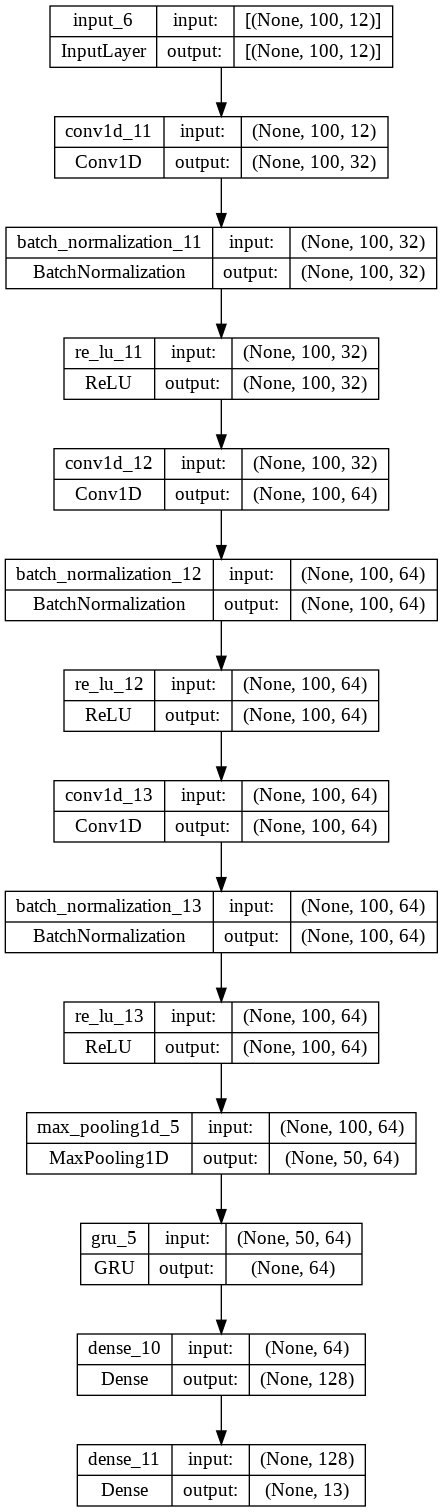

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint("mhealth_best.h5", save_best_only=True, monitor="val_loss"),
             keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1)]
 
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"],)
 
model_history = model.fit(X_train,y_train, epochs= 10, validation_data=(X_test,y_test), callbacks=callbacks)

Epoch 1/10
154/154 [==============================] - 13s 65ms/step - loss: 0.8787 - sparse_categorical_accuracy: 0.7377 - val_loss: 0.8022 - val_sparse_categorical_accuracy: 0.6636
Epoch 2/10
154/154 [==============================] - 9s 61ms/step - loss: 0.1190 - sparse_categorical_accuracy: 0.9663 - val_loss: 0.1158 - val_sparse_categorical_accuracy: 0.9713
Epoch 3/10
154/154 [==============================] - 9s 61ms/step - loss: 0.0574 - sparse_categorical_accuracy: 0.9840 - val_loss: 0.0565 - val_sparse_categorical_accuracy: 0.9814
Epoch 4/10
154/154 [==============================] - 9s 61ms/step - loss: 0.0330 - sparse_categorical_accuracy: 0.9903 - val_loss: 0.0298 - val_sparse_categorical_accuracy: 0.9946
Epoch 5/10
154/154 [==============================] - 9s 61ms/step - loss: 0.0222 - sparse_categorical_accuracy: 0.9945 - val_loss: 0.0710 - val_sparse_categorical_accuracy: 0.9821
Epoch 6/10
154/154 [==============================] - 9s 61ms/step - loss: 0.0419 - sparse_cat

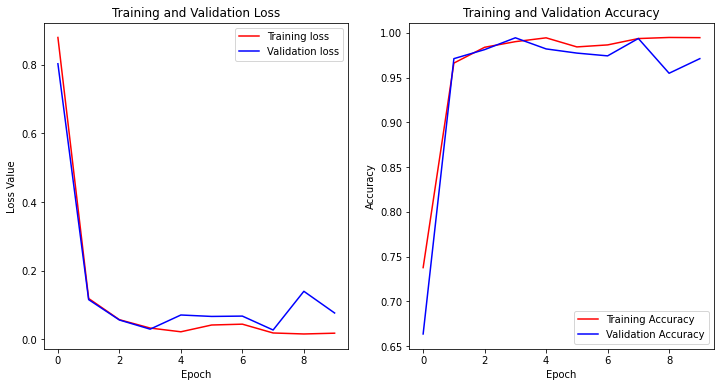

In [ ]:
train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
train_accuracy = model_history.history['sparse_categorical_accuracy']
val_accuracy = model_history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
model = keras.models.load_model('./mhealth_best.h5')

train_loss, train_acc = model.evaluate(X_train,y_train)
test_loss, test_acc = model.evaluate(X_test,y_test)

print("Train accuracy", round(train_acc*100, 1),'%')
print("Train loss", train_loss)
print("Test accuracy", round(test_acc*100, 1),'%')
print("Test loss", test_loss)

41/41 [==============================] - 1s 15ms/step - loss: 0.0273 - sparse_categorical_accuracy: 0.9938
Train accuracy 99.9 %
Train loss 0.004560741595923901
Test accuracy 99.4 %
Test loss 0.027341298758983612


In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred, axis = 1)
pred = pred.reshape(-1,1)
pred.shape,y_test.shape

41/41 [==============================] - 1s 15ms/step


((1287, 1), (1287, 1))

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
 
print(classification_report(y_test,pred))
print('*'*50)
print(confusion_matrix(y_test,pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        93
           1       0.99      1.00      1.00       123
           2       1.00      0.98      0.99       123
           3       0.98      1.00      0.99       122
           4       1.00      0.99      1.00       120
           5       0.99      1.00      0.99        84
           6       0.99      1.00      1.00       106
           7       1.00      0.98      0.99       112
           8       0.97      0.99      0.98       116
           9       1.00      0.99      1.00       121
          10       1.00      1.00      1.00        88
          11       1.00      1.00      1.00        52
          12       1.00      0.96      0.98        27

    accuracy                           0.99      1287
   macro avg       0.99      0.99      0.99      1287
weighted avg       0.99      0.99      0.99      1287

**************************************************
[[ 93   0   0   0   0   0   

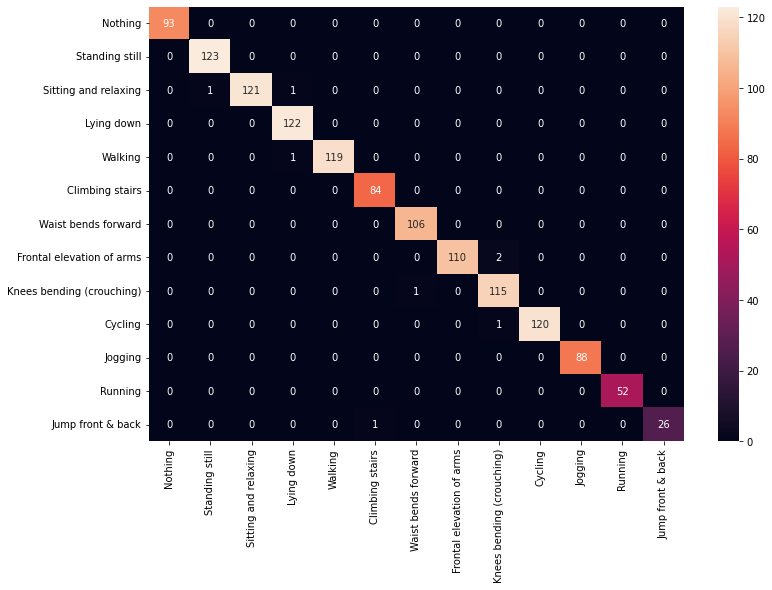

In [ ]:
plt.figure(figsize=(12,8))
conf_matrix = confusion_matrix(y_test,pred)
sns.heatmap(conf_matrix, xticklabels= label_map.values(), yticklabels= label_map.values(), annot=True, fmt="d")
plt.show()